Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] If you log-transformed your regression target, then convert your PDP back to original units. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [2]:
import sys, getpass
a = getpass.getuser()
### example appending of folder
sys.path.append('/Users/{}/Programs/BFLibrary/'.format(a))
#from BFLibrary import ACompass, BWarp, CToolbox 
import AMap as am
import BCook as bc
import CTools as ct
import pandas as pd
pd.options.display.float_format = None
df = pd.read_excel('~/Downloads/CoralBleaching.xlsm')

In [3]:
target = 'BLEACHING_SEVERITY'

# Let's group by bleaching or not.
df[target] = df[target].replace({
    'Low':1, 'HIGH':1, 'Medium':1, 'Severity Unknown':1,
    'No Bleaching':0})

### ID 29433 LAT is actually -10.269
df['LAT'] = df['LAT'].replace({-10269:-10.269})

In [4]:
features, num_feats, cat_feats = bc.allPantryFeatures(df)

In [5]:
### Drop some columns w/ almost no values
df = bc.diceBadCols(df, features, percent=60)
# Drop always unique ID
df.drop('ID', axis=1, inplace=True)

In [6]:
test_mask = (df['YEAR'] > 2005)
val_mask = (
    (df['YEAR'] > 2003) &
    (df['YEAR'] <= 2005)
)
train_mask = (df['YEAR'] <= 2003)
test = df[test_mask]
train = df[train_mask]
val = df[val_mask]
print(train.shape, val.shape, test.shape,"\n",
      "Sum of shapes:", train.shape[0]+val.shape[0]+test.shape[0],"\n",
      "Total dataframe shape:", df.shape[0])

(4167, 14) (965, 14) (1058, 14) 
 Sum of shapes: 6190 
 Total dataframe shape: 6190


In [7]:
# Get features from train after I chopped em'
features, num_feats, cat_feats = bc.allPantryFeatures(train)
X_train = train[features].drop(target,axis=1)
y_train = train[target]
X_val = val[features].drop(target,axis=1)
y_val = val[target]

In [8]:
# Majority class baseline
y_train.value_counts(normalize=True)

1    0.75594
0    0.24406
Name: BLEACHING_SEVERITY, dtype: float64

# Modeling Time

In [ ]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [9]:
%%time

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=4)
)
pipeline.fit(X_train,y_train)

CPU times: user 204 ms, sys: 48.6 ms, total: 252 ms
Wall time: 263 ms


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['REGION', 'SUBREGION', 'COUNTRY',
                                      'LOCATION', 'DEPTH', 'REMARKS', 'SOURCE',
                                      'COUNTRY_CODE'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'REGION',
                                          'data_type': dtype('O'),
                                          'mapping': NaN            1
Africa         2
Americas       3
Asia           4
Australia      5
Middle East    6
Pacific        7
dtype: int64},
                                         {'col'...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_fe

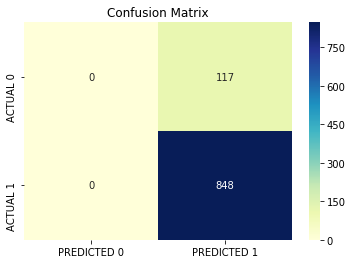

In [10]:
y_pred = pipeline.predict(X_val)
accuracy_score(y_val,y_pred)
am.plotConfusionMatrix(y_val,y_pred)

In [11]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.88      1.00      0.94       848

    accuracy                           0.88       965
   macro avg       0.44      0.50      0.47       965
weighted avg       0.77      0.88      0.82       965



//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

1.0